# Amazon SageMaker Asynchronous Endpoints - Computer Vision

---

본 예제 코드는 [AWS AIML Blog](https://aws.amazon.com/ko/blogs/machine-learning/run-computer-vision-inference-on-large-videos-with-amazon-sagemaker-asynchronous-endpoints/)에 공개된 예제 코드를 기반으로 자체적으로 아래 개선점들을 반영하였습니다.

- OpenCV 프로세싱 오류 수정
- 로컬 환경 디버깅 예시 및 로컬 모드 예시 추가
- 추론 결괏값 처리 및 시각화 로직 추가
- 마이너 버그 개선

### References

- AWS Blog: https://aws.amazon.com/ko/blogs/machine-learning/run-computer-vision-inference-on-large-videos-with-amazon-sagemaker-asynchronous-endpoints/
- GitHub: https://github.com/aws-samples/amazon-sagemaker-asynchronous-inference-computer-vision

### Background

처리 시간이 수 분 이상 걸릴 수 있는 대규모 입력 페이로드를 사용하는 유즈케이스가 증가하고 있습니다.
예를 들어, 우주 기술 회사는 고해상도 위성 이미지 스트림을 사용하여 관심 있는 특정 물체를 감지합니다. 유사하게, 의료 회사는 이상을 감지하기 위해 심초음파와 같은 고해상도 생체의학 이미지 또는 비디오를 처리합니다. 또한 미디어 회사는 고객이 업로드한 이미지와 비디오를 스캔하여 규정을 준수하고 저작권 위반이 없는지 확인합니다. 이러한 애플리케이션들은 하루 중 다른 시간에 들어오는 트래픽 버스트를 수신하고 저렴한 비용으로 완료 알림과 함께 실시간에 가까운 처리가 필요합니다.

이 노트북에서는 대규모 입력 페이로드 비디오의 트래픽 버스트를 처리하는 SageMaker 비동기(asynchronous) 추론 엔드포인트를 배포합니다. 최소 1개 이상의 인스턴스가 필요한 실시간 호스팅 엔드포인트와 달리 비동기 엔드포인트는 인스턴스를 0으로 축소할 수 있습니다. 이 기능을 사용하면 트래픽이 없을 때 인스턴스를 0으로 축소하기에 비용을 절감할 수 있습니다.


### Difference between Real-time endpoint and Asynchronous endpoint
비동기식 엔드포인트를 생성하는 프로세스는 실시간 엔드포인트와 동일합니다. (Model 생성 - EndpointConfig 생성 - Endpoint 생성)

실시간 엔드포인트와의 가장 큰 차이점은 요청 페이로드(request payload)를 인라인으로 전달하는 대신 페이로드를 Amazon S3에 업로드하고 Amazon S3 URI를 요청의 일부로 전달합니다. 요청을 받으면 SageMaker는 처리 후 결과가 저장될 출력 경로가 포함된 토큰을 제공합니다. 내부적으로 SageMaker는 이러한 요청이 있는 대기열을 자동으로 유지 관리하고 처리합니다. 또한, 엔드포인트를 생성하는 동안 선택적으로 Amazon SNS topic을 지정하여 성공 또는 오류 알림을 받을 수 있습니다. 추론 요청이 성공적으로 처리되었다는 알림을 받으면 Amazon S3를 통해 결괏값을 확인할 수 있습니다.

<br>

## 0. Pre-requisites
---

### Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torchvision
import torchvision.models as models
import sagemaker
from sagemaker import get_execution_role
from sagemaker.utils import name_from_base
from sagemaker.pytorch import PyTorchModel
import boto3
import datetime
import time
from time import strftime,gmtime
import json
import os
import urllib
import sys
import io
import torchvision.transforms as transforms

role = get_execution_role()
boto_session = boto3.session.Session()
sm_session = sagemaker.session.Session()
sm_client = boto_session.client("sagemaker")
sm_runtime = boto_session.client("sagemaker-runtime")
sns_client = boto3.client('sns')
region = boto_session.region_name
bucket = sm_session.default_bucket()
prefix = 'async-inference-maskrcnn'

print(region)
print(role)
print(bucket)
print(prefix)

us-east-1
arn:aws:iam::143656149352:role/service-role/SageMakerExecRole-team-clouddev
sagemaker-us-east-1-143656149352
async-inference-maskrcnn


### IAM Role 

AWS IAM 콘솔(https://console.aws.amazon.com/iam/home)로 이동하여 IAM 역할(role)에 다음 정책(policy)을 추가합니다.

* SageMakerFullAccessPolicy
* Amazon S3 access: GetObject/PutObject 권한을 적용합니다. `bucket_name`을 여러분의 Amazon S3 버킷의 이름으로 변경하세요.
```json
{
    "Version": "2012-10-17",
    "Statement": [
        {
            "Action": [
                "s3:GetObject",
                "s3:PutObject",
                "s3:AbortMultipartUpload",
                "s3:ListBucket"
            ],
            "Effect": "Allow",
            "Resource": "arn:aws:s3:::bucket_name/*"
        }
    ]
}
```

* (Optional) Amazon SNS access: 정의한 토픽에 `sns:Publish`를 추가하세요. Amazon SNS를 사용하여 알림을 수신하려는 경우 적용합니다.

```json
{
    "Version": "2012-10-17",
    "Statement": [
        {
            "Action": [
                "sns:Publish"
            ],
            "Effect": "Allow",
            "Resource": "arn:aws:sns:us-east-2:123456789012:MyTopic"
        }
    ]
}
```

* (Optional) KMS decrypt, encrypt if your Amazon S3 bucket is encrypte.

### Inference Script

SageMaker 추론 스크립트는 SageMaker 상에서 MXNet에 최적화된 추론 서버인 MMS(Multi Model Server)나 PyTorch에 최적화된 추론 서버인 torchserve를 쉽고 편하게 배포할 수 있는 high-level 툴킷인 SageMaker inference toolkit의 인터페이스를 사용하고 있으며, 여러분께서는 인터페이스에 정의된 핸들러(handler) 함수들만 구현하시면 됩니다. MXNet 및 PyTorch용 엔트리포인트(entrypoint) 인터페이스는 아래 두 가지 옵션 중 하나를 선택하면 되며, 본 예제에서는 Option 2.의 사용 예시를 보여줍니다.


#### Option 1.
- `model_fn(model_dir)`: 딥러닝 네트워크 아키텍처를 정의하고 S3의 model_dir에 저장된 모델 아티팩트를 로드합니다.
- `input_fn(request_body, content_type)`: 입력 데이터를 전처리합니다. (예: request_body로 전송된 bytearray 배열을 PIL.Image로 변환 수 cropping, resizing, normalization등의 전처리 수행). content_type은 입력 데이터 종류에 따라 다양하게 처리 가능합니다. (예: application/x-npy, application/json, application/csv 등)
- `predict_fn(input_object, model)`: input_fn을 통해 들어온 데이터에 대해 추론을 수행합니다.
- `output_fn(prediction, accept_type)`: predict_fn에서 받은 추론 결과를 추가 변환을 거쳐 프론트 엔드로 전송합니다.

#### Option 2.
- `model_fn(model_dir)`: 딥러닝 네트워크 아키텍처를 정의하고 S3의 model_dir에 저장된 모델 아티팩트를 로드합니다.
- `transform_fn(model, request_body, content_type, accept_type)`: input_fn(), predict_fn(), output_fn()을 transform_fn()으로 통합할 수 있습니다.

In [3]:
%%writefile src/inference.py

import cv2
import json
import torch
import torchvision.transforms as transforms
from six import BytesIO
import io
import numpy as np
import tempfile

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def video2frame(file_path, frame_width, frame_height, interval):
    """
    Extract frame from video by interval
    :param video_src_path: video src path
    :param video:　video file name
    :param frame_width:　frame width
    :param frame_height:　frame height
    :param interval:　interval for frame to extract
    :return:　list of numpy.ndarray 
    """
    video_frames = []
    cap = cv2.VideoCapture(file_path)
    frame_index = 0
    frame_count = 0
    if cap.isOpened():
        success = True
    else:
        success = False
        print("Read failed!")

    while success:
        success, frame = cap.read()
        if frame_index % interval == 0:
            print("---> Reading the %d frame:" % frame_index, success)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            resize_frame = cv2.resize(
                frame, (frame_width, frame_height), interpolation=cv2.INTER_AREA
            )
            video_frames.append(resize_frame)
            frame_count += 1

        frame_index += 1

    cap.release()
    print(f'Total frames={frame_index}, Number of extracted frames={frame_count}')
    return video_frames


def model_fn(model_dir):
    '''
    Loads the model into memory from storage and return the model.
    '''    
    model = torch.load(model_dir + '/model.pth', map_location=torch.device(device))
    model = model.eval()
    return model


def input_fn(request_body, request_content_type=None):
    frame_width = 256
    frame_height = 256
    interval = 30
    print("content_type=")
    print(request_content_type)
    
    f = io.BytesIO(request_body)
    with tempfile.NamedTemporaryFile(delete=False) as tfile:
        tfile.write(f.read())
        filename = tfile.name
    
    video_frames = video2frame(filename, frame_width, frame_height, interval)  
    return video_frames


def predict_fn(video_frames, model):
    transform = transforms.Compose([
        transforms.Lambda(lambda video_frames: torch.stack([transforms.ToTensor()(frame) for frame in video_frames])) # returns        a 4D tensor
    ])
    image_tensors = transform(video_frames).to(device)
    
    with torch.no_grad():
        output = model(image_tensors)
    return output


def output_fn(output_batch, accept='application/json'):
    res = []
    
    print(f'output list length={len(output_batch)}')
    for output in output_batch:
        boxes = output['boxes'].detach().cpu().numpy()
        labels = output['labels'].detach().cpu().numpy()
        scores = output['scores'].detach().cpu().numpy()
        masks = output['masks'].detach().cpu().numpy()
        masks = np.squeeze(masks.transpose(2,3,0,1)) # 4D(batch x 1 height x width) to 3D(height x width x batch)
        
        res.append({
            'boxes': boxes.tolist(),
            'labels': labels.tolist(),
            'scores': scores.tolist(),
            'masks': masks.tolist()     
        })
    
    return json.dumps(res)

Overwriting src/inference.py


### Visualization

Instance Segmentation 결괏값을 시각화합니다.

In [4]:
%%writefile src/visualize.py

import numpy as np
import colorsys
from skimage.measure import find_contours
import random
import matplotlib.pyplot as plt
from matplotlib import patches, lines
from matplotlib.patches import Polygon

def get_label_map(label_file):
    label_map = {}
    labels = open(label_file, 'r')
    
    for line in labels:
        line = line.rstrip("\n")
        ids = line.split(',')
        label_map[int(ids[0])] = ids[2] 
        
    return label_map


def random_colors(N, bright=False):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """    
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors


def apply_mask(image, mask, color, alpha=0.3):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image


def display_instances(image, boxes, masks, class_ids, class_names,
                      scores=None, title="", 
                      score_thres=0.5, mask_thres=0.5,
                      figsize=(10, 10), ax=None,
                      show_mask=True, show_bbox=True,
                      colors=None, framework='pytorch'):
    """
    boxes: [num_instance, (x1, y1, x2, y2, class_id)] in image coordinates.
    masks: [height, width, num_instances]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    title: (optional) Figure title
    score_thres: To return only objects whose score is greater than to a certain value in the detected result.
    mask_thres: Threshold for binarizing the mask image
    figsize: (optional) the size of the image
    show_mask, show_bbox: To show masks and bounding boxes or not    
    colors: (optional) An array or colors to use with each object
    framework: pytorch/mxnet
    """
    
    if framework == 'mxnet':
        boxes = boxes.asnumpy()
        masks = masks.asnumpy()
        scores = scores.asnumpy()        
    else:
        boxes = np.array(boxes)
        masks = np.array(masks)   
        scores = np.array(scores)        
    
    # Get only results that are above the threshold. Default threshold is 0.5. 
    scores = scores[scores > score_thres]
    # Number of instances
    N = len(scores)

    if not N:
        print("\n*** No instances to display *** \n")

    # If no axis is passed, create one and automatically call show()
    auto_show = False
    if not ax:
        _, ax = plt.subplots(1, figsize=figsize)
        auto_show = True

    # Generate random colors
    colors = colors or random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)
    masked_image = image.astype(np.uint32).copy()
    
    for i in range(N):
        color = colors[i]

        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        x1, y1, x2, y2 = boxes[i]
            
        if show_bbox:
            p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                                alpha=0.7, linestyle="dashed",
                                edgecolor=color, facecolor='none')
            ax.add_patch(p)

        # Label
        class_id = class_ids[i]
        score = scores[i] if scores is not None else None
        #predicted_class = class_info[int(cls_pred)]
        label = class_names[int(class_id)]
        caption = "{} {:.3f}".format(label, score) if score else label
        ax.text(x1, y1, caption, color='w', verticalalignment='top',
                size=12, bbox={'color': color, 'pad': 0})           

        # Mask
        mask = (masks[:, :, i] > mask_thres) * 1
        if show_mask:
            masked_image = apply_mask(masked_image, mask, color)

        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        padded_mask = np.zeros(
            (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)

        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
            # Subtract the padding and flip (y, x) to (x, y)
            verts = np.fliplr(verts) - 1
            p = Polygon(verts, facecolor="none", edgecolor=color)
            ax.add_patch(p)
    ax.imshow(masked_image.astype(np.uint8))
    if auto_show:
        plt.show()
        
    #return masked_image

Overwriting src/visualize.py


<br>

## 1. Local Endpoint Inference
---

먼저, 로컬 개발 환경에서 추론 결과를 확인합니다. 로컬에서 충분히 디버깅 후 호스팅 엔드포인트로 배포해야 합니다.

In [5]:
from src.visualize import get_label_map, display_instances
from src.inference import model_fn, input_fn, predict_fn, output_fn

사전 훈련된 ResNet-50 기반 Mask-RCNN 모델을 사용합니다. 여러분의 모델을 준비하셔도 됩니다.

In [6]:
model = models.detection.maskrcnn_resnet50_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /home/ec2-user/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

### Download Sample Movie Clip
GluonCV의 샘플 무비클립을 다운로드합니다.

In [8]:
video_path = 'https://raw.githubusercontent.com/dmlc/web-data/master/gluoncv/tracking/Coke.mp4'
!rm -rf videos & mkdir videos 
video_local_path = 'videos/Coke.mp4'
!wget $video_path -O $video_local_path

with open(video_local_path, mode='rb') as file:
    request_body = bytearray(file.read())

--2022-01-20 00:37:35--  https://raw.githubusercontent.com/dmlc/web-data/master/gluoncv/tracking/Coke.mp4
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9883772 (9.4M) [application/octet-stream]
Saving to: ‘videos/Coke.mp4’

100%[======================================>] 9,883,772   --.-K/s   in 0.03s   

2022-01-20 00:37:36 (275 MB/s) - ‘videos/Coke.mp4’ saved [9883772/9883772]



### Save Model
모델을 로컬 폴더로 저장합니다.

**[참고]** 사전 훈련된 모델을 fine-tuning 없이 사용하는 경우 0바이트의 `model.tar.gz`로 아카이빙하는 것도 가능합니다. 물론 이 경우는 인터넷 연결이 활성화되어야 합니다.

In [9]:
model_path = 'model'
!rm -rf $model_path & mkdir $model_path
torch.save(model, f'{model_path}/model.pth') 

### Local Inference without Endpoint
SageMaker 호스팅 인스턴스로 배포하기 전, SageMaker 추론에서 사용하는 인터페이스로 충분히 테스트를 수행합니다. 

In [10]:
model = model_fn(model_path)
video_frames = input_fn(request_body)
preds = predict_fn(video_frames, model)
output = output_fn(preds)

content_type=
None
---> Reading the 0 frame: True
---> Reading the 30 frame: True
---> Reading the 60 frame: True
---> Reading the 90 frame: True
---> Reading the 120 frame: True
---> Reading the 150 frame: True
---> Reading the 180 frame: True
---> Reading the 210 frame: True
---> Reading the 240 frame: True
---> Reading the 270 frame: True
Total frames=292, Number of extracted frames=10
output list length=10


### Visualization
자체 구현한 시각화 함수로 Mask R-CNN의 Instance Segmentation 결괏값을 출력합니다. 예제 코드에서는 첫번째 프레임 결과만 확인하지만 모든 프레임에 대한 결괏값을 확인할 수도 있습니다. 

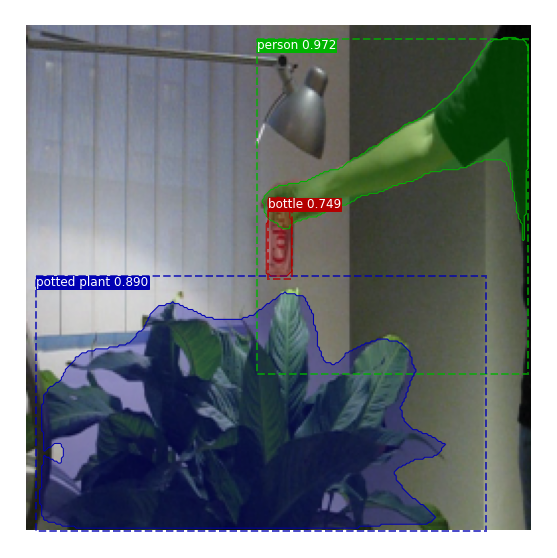

In [11]:
output_json = json.loads(output)
label_map = get_label_map('src/coco_labels.txt')

display_instances(
    image=video_frames[0], 
    boxes=output_json[0]['boxes'], 
    masks=output_json[0]['masks'],
    class_ids=output_json[0]['labels'], 
    class_names=label_map,
    scores=output_json[0]['scores']
)

### Create model archive and upload to S3

SageMaker 호스팅 인스턴스 배포를 위해 모델 파라메터와 소스 코드를 model.tar.gz로 아카이빙하여 S3로 복사합니다.
PyTorch 1.2 버전부터는 아래 규칙으로 아카이빙해야 합니다.

```
model.tar.gz/
|- model.pth
|- code/
  |- inference.py
  |- requirements.txt  # only for versions 1.3.1 and higher
```

참고로, SageMaker Python SDK를 사용하는 경우, 인자값에 소스 코드 디렉토리와 소스 코드를 명시해 주면 자동으로 모델 파라메터와 소스 코드를 아카이빙해 줍니다.

In [12]:
model_artifact_path = 'model_and_code'

!rm -rf $model_artifact_path
!mkdir $model_artifact_path
!mkdir $model_artifact_path/code
torch.save(model, f'{model_artifact_path}/model.pth')
!cp ./src/* $model_artifact_path/code
!tar cvzf model.tar.gz -C $model_artifact_path/ . 

cp: omitting directory ‘./src/__pycache__’
./
./code/
./code/visualize.py
./code/requirements.txt
./code/coco_labels.txt
./code/inference.py
./model.pth


In [13]:
from sagemaker.s3 import S3Uploader
file_key = 'model.tar.gz'
model_artifact = S3Uploader.upload(file_key,'s3://{}/{}/model'.format(bucket, prefix))
print(model_artifact)

s3://sagemaker-us-east-1-143656149352/async-inference-maskrcnn/model/model.tar.gz


<br>

## 2. (Optional - SageMaker Only) Local Mode 
---

충분한 검증 및 테스트 없이 훈련된 모델을 곧바로 실제 운영 환경에 배포하기에는 많은 위험 요소들이 있습니다. 따라서, 로컬 모드를 사용하여 실제 운영 환경에 배포하기 위한 추론 인스턴스를 시작하기 전에 노트북 인스턴스의 로컬 환경에서 모델을 배포하는 것을 권장합니다. 이를 로컬 모드 엔드포인트(Local Mode Endpoint)라고 합니다.

In [ ]:
local_model_path = f'file://{os.getcwd()}/model.tar.gz'

model = PyTorchModel(model_data=local_model_path,
                     role=role,
                     entry_point='inference.py', 
                     source_dir='src',
                     framework_version='1.7.1',
                     py_version='py3')

predictor = model.deploy(
    initial_instance_count=1,
    instance_type='local'
)

### Create SageMaker model with PyTorch inference container

In [ ]:
local_sm_runtime = sagemaker.local.LocalSagemakerRuntimeClient()
local_endpoint_name = model.endpoint_name

feed_data = open('images/birds.jpg', 'rb')
response = local_sm_runtime.invoke_endpoint(
    EndpointName=local_endpoint_name, 
    Body=feed_data
)
output_json = json.loads(response['Body'].read())

In [ ]:
import numpy as np
from PIL import Image
img = Image.open('images/birds.jpg').resize((256, 256))

display_instances(
    image=np.array(img), 
    boxes=output_json[0]['boxes'], 
    masks=output_json[0]['masks'],
    class_ids=output_json[0]['labels'], 
    class_names=label_map,
    scores=output_json[0]['scores']
)

In [ ]:
predictor.delete_endpoint()

<br>

## 3. Create Asynchronous inference endpoint
---

비동기 엔드포인트를 생성합니다. 생성 방법은 기존 실시간 호스팅 엔드포인트와 거의 동일하며, EndpointConfig 생성 시 AsyncInferenceConfig만 명시해 주시면 됩니다.

### (Optional) Create Error and Success SNS topics

In [ ]:
response = sns_client.create_topic(Name="Async-Demo-ErrorTopic")
error_topic= response['TopicArn']
print(error_topic)

response = sns_client.create_topic(Name="Async-Demo-SuccessTopic")
success_topic = response['TopicArn']
print(success_topic)

In [ ]:
response = sns_client.list_topics()
topics = response["Topics"]
print(topics)

In [ ]:
#Note: Replace with your email id

email_id = 'YOUR-EMAIL'
email_sub_1 = sns_client.subscribe(
    TopicArn=success_topic,
    Protocol='email',
    Endpoint=email_id)

email_sub_2 = sns_client.subscribe(
    TopicArn=error_topic,
    Protocol='email',
    Endpoint=email_id)

#Note: You will need to confirm by clicking on the email you recieve to complete the subscription

### Create Model

In [14]:
from sagemaker.image_uris import retrieve

deploy_instance_type = 'ml.g4dn.xlarge'
pytorch_inference_image_uri = retrieve(
    'pytorch',
    region,
    version='1.7.1',
    py_version='py3',
    instance_type = deploy_instance_type,
    accelerator_type=None,
    image_scope='inference'
)

container = pytorch_inference_image_uri
model_name = 'sagemaker-maskrcnn-{0}'.format(str(int(time.time())))

create_model_response = sm_client.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = {
        'Image': container,
        'ModelDataUrl': model_artifact,
        'Environment': {
            'TS_MAX_REQUEST_SIZE': '100000000', #default max request size is 6 Mb for torchserve, need to update it to support the 70 mb input payload
            'TS_MAX_RESPONSE_SIZE': '100000000',
            'TS_DEFAULT_RESPONSE_TIMEOUT': '1000'
        }
    },    
)

print(f"Created Model: {create_model_response['ModelArn']}")
print(container)
print(model_name)      

Created Model: arn:aws:sagemaker:us-east-1:143656149352:model/sagemaker-maskrcnn-1642639166
763104351884.dkr.ecr.us-east-1.amazonaws.com/pytorch-inference:1.7.1-gpu-py3
sagemaker-maskrcnn-1642639166


### Create EndpointConfig

모델을 생성했으면, EndpointConfig를 생성합니다. Amazon SageMaker 호스팅 서비스는 EndpointConfig를을 사용하여 모델을 배포하며 비동기 추론 시에는 AsyncInferenceConfig 인자값에 OutputConfig에 대한 출력 Amazon S3 경로를 지정합니다. 또한, 선택적으로 추론 결괏값에 대한 알림을 보낼 Amazon SNS 주제를 지정할 수 있습니다.

In [15]:
bucket_prefix = "async-inference-example"
endpoint_config_name = f"PyTorchAsyncEndpointConfig-{strftime('%Y-%m-%d-%H-%M-%S', gmtime())}"
create_endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "VariantName": "variant1",
            "ModelName": model_name,
            "InstanceType": "ml.g4dn.xlarge",
            "InitialInstanceCount": 1
        }
    ],
    AsyncInferenceConfig={
        "OutputConfig": {
            "S3OutputPath": f"s3://{bucket}/{bucket_prefix}/output",
            #  Optionally specify Amazon SNS topics
#             "NotificationConfig": {
#               "SuccessTopic": success_topic,
#               "ErrorTopic": error_topic,
#             }
        },
        "ClientConfig": {
            "MaxConcurrentInvocationsPerInstance": 2
        }
    }
)
print(f"Created EndpointConfig: {create_endpoint_config_response['EndpointConfigArn']}")

Created EndpointConfig: arn:aws:sagemaker:us-east-1:143656149352:endpoint-config/pytorchasyncendpointconfig-2022-01-20-00-39-31


### Create Endpoint

SageMaker 엔드포인트를 생성합니다. 호스팅 인스턴스를 프로비저닝하는 데 약 5분에서 10분의 시간이 소요됩니다.

**[Note]** 향후 오토스케일링이나 AB 테스트 설정 변경 시에 엔드포인트를 재배포할 필요가 없이 신규 EndpointConfig 생성 후 update_endpoint()로 엔드포인트를 업데이트하면 됩니다. 아래 코드 예시를 참조하세요.

```
sm_client.create_endpoint_config(...)
response = sm_client.update_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name
)
```

In [16]:
endpoint_name = f"sm-{strftime('%Y-%m-%d-%H-%M-%S', gmtime())}"
create_endpoint_response = sm_client.create_endpoint(EndpointName=endpoint_name, EndpointConfigName=endpoint_config_name)
print(f"Creating Endpoint: {create_endpoint_response['EndpointArn']}")

Creating Endpoint: arn:aws:sagemaker:us-east-1:143656149352:endpoint/sm-2022-01-20-00-39-33


In [19]:
from IPython.core.display import display, HTML

def make_endpoint_link(region, endpoint_name, endpoint_task):
    endpoint_link = f'<b><a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={region}#/endpoints/{endpoint_name}">{endpoint_task} Review Endpoint</a></b>'   
    return endpoint_link 
        
endpoint_link = make_endpoint_link(region, endpoint_name, '[Asynchronous Endpoint]')
display(HTML(endpoint_link))

In [21]:
waiter = boto3.client('sagemaker').get_waiter('endpoint_in_service')
print("Waiting for endpoint to create...")
waiter.wait(EndpointName=endpoint_name)
resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
print(f"Endpoint Status: {resp['EndpointStatus']}")

Waiting for endpoint to create...
Endpoint Status: InService


<br>

## 4. Asynchronous Inference
---

### Upload input video file

In [22]:
def upload_file(bucket, bucket_prefix, input_location):
    prefix = f"{bucket_prefix}/input"
    return sm_session.upload_data(
        input_location, 
        bucket=bucket,
        key_prefix=prefix, 
        extra_args={"ContentType": "video/mp4"})

In [23]:
input_1_location = "videos/Coke.mp4"
input_1_s3_location = upload_file(bucket, bucket_prefix, input_1_location)
print(input_1_s3_location)

s3://sagemaker-us-east-1-143656149352/async-inference-example/input/Coke.mp4


### Invoke asynchronous endpoint

In [24]:
sm_client = boto_session.client("sagemaker")
sm_runtime = boto_session.client("sagemaker-runtime")

In [25]:
response = sm_runtime.invoke_endpoint_async(
    EndpointName=endpoint_name, 
    InputLocation=input_1_s3_location
)
output_location = response['OutputLocation']
print(f"OutputLocation: {output_location}")

OutputLocation: s3://sagemaker-us-east-1-143656149352/async-inference-example/output/d80db7d5-6174-46d2-a451-365a23834a54.out


In [26]:
%%time
from botocore.exceptions import ClientError

def get_output(output_location):
    output_url = urllib.parse.urlparse(output_location)
    bucket = output_url.netloc
    key = output_url.path[1:]
    while True:
        try:
            return sm_session.read_s3_file(bucket=output_url.netloc, key_prefix=output_url.path[1:])
        except ClientError as e:
            if e.response['Error']['Code'] == 'NoSuchKey':
                print("waiting for output...")
                time.sleep(10)
                continue
            raise

def convert_size(size_bytes):
    import math
    if size_bytes == 0:
        return "0B"
    size_name = ("B", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
    i = int(math.floor(math.log(size_bytes, 1024)))
    p = math.pow(1024, i)
    s = round(size_bytes / p, 2)
    return "%s %s" % (s, size_name[i])

output = get_output(output_location)
output_size_bytes = sys.getsizeof(output)
print(f"Output size={output_size_bytes} bytes, {convert_size(output_size_bytes)}")

waiting for output...
Output size=53168340 bytes, 50.71 MB
CPU times: user 79.2 ms, sys: 143 ms, total: 223 ms
Wall time: 10.7 s


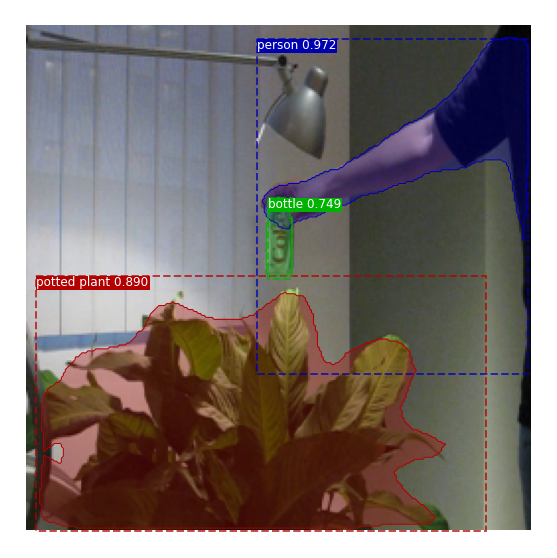

In [27]:
output_json = json.loads(output)
num_results = len(output_json)
label_map = get_label_map('src/coco_labels.txt')

display_instances(
    image=video_frames[0], 
    boxes=output_json[0]['boxes'], 
    masks=output_json[0]['masks'],
    class_ids=output_json[0]['labels'], 
    class_names=label_map,
    scores=output_json[0]['scores']
)

### Trigger 10 asynchronous requests on a single instance 

In [28]:
inferences = []

for i in range(1,10):
    start = time.time()
    response = sm_runtime.invoke_endpoint_async(
    EndpointName=endpoint_name, 
    InputLocation=input_1_s3_location)
    output_location = response["OutputLocation"]
    inferences += [(input_1_s3_location, output_location)]
    time.sleep(0.5)
print("\Async invocations for Pytorch serving default: \n")

for input_file, output_location in inferences:
    output = get_output(output_location)
    print(f"Input File: {input_file}, Output location: {output_location}")

\Async invocations for Pytorch serving default: 

waiting for output...
Input File: s3://sagemaker-us-east-1-143656149352/async-inference-example/input/Coke.mp4, Output location: s3://sagemaker-us-east-1-143656149352/async-inference-example/output/b4875464-9440-4759-a423-2f89e9493a5e.out
Input File: s3://sagemaker-us-east-1-143656149352/async-inference-example/input/Coke.mp4, Output location: s3://sagemaker-us-east-1-143656149352/async-inference-example/output/59e3859b-a1a7-4068-a5df-ec6998709ed5.out
waiting for output...
Input File: s3://sagemaker-us-east-1-143656149352/async-inference-example/input/Coke.mp4, Output location: s3://sagemaker-us-east-1-143656149352/async-inference-example/output/66bf6d83-b6fb-4a67-81f9-a883c6b9f549.out
waiting for output...
waiting for output...
Input File: s3://sagemaker-us-east-1-143656149352/async-inference-example/input/Coke.mp4, Output location: s3://sagemaker-us-east-1-143656149352/async-inference-example/output/6868e684-dbee-49a5-84d2-53d2cbf64ca

<br>

## 5. (Optional) AutoScaling
---
[주의] 본 섹션은 필수가 아니기에 선택적으로 진행하세요. 


### (Optional) Setup AutoScaling policy

Application Autoscaling을 활성화하여 비동기 엔드포인트에서 Autoscaling을 구성합니다.

In [32]:
enable_autoscaling = False 

if enable_autoscaling:
    client = boto3.client('application-autoscaling') # Common class representing Application Auto Scaling for SageMaker amongst other services

    resource_id = 'endpoint/' + endpoint_name + '/variant/' + 'variant1' # This is the format in which application autoscaling references the endpoint

    # Configure Autoscaling on asynchronous endpoint down to zero instances
    response = client.register_scalable_target(
        ServiceNamespace='sagemaker', 
        ResourceId=resource_id,
        ScalableDimension='sagemaker:variant:DesiredInstanceCount',
        MinCapacity=0,  
        MaxCapacity=5
    )

    response = client.put_scaling_policy(
        PolicyName='Invocations-ScalingPolicy',
        ServiceNamespace='sagemaker', # The namespace of the AWS service that provides the resource. 
        ResourceId=resource_id, # Endpoint name 
        ScalableDimension='sagemaker:variant:DesiredInstanceCount', # SageMaker supports only Instance Count
        PolicyType='TargetTrackingScaling', # 'StepScaling'|'TargetTrackingScaling'
        TargetTrackingScalingPolicyConfiguration={
            'TargetValue': 5.0, # The target value for the metric. 
            'CustomizedMetricSpecification': {
                'MetricName': 'ApproximateBacklogSizePerInstance',
                'Namespace': 'AWS/SageMaker',
                'Dimensions': [
                    {'Name': 'EndpointName', 'Value': endpoint_name }
                ],
                'Statistic': 'Average',
            },
            'ScaleInCooldown': 120, # The cooldown period helps you prevent your Auto Scaling group from launching or terminating 
                                    # additional instances before the effects of previous activities are visible. 
                                    # You can configure the length of time based on your instance startup time or other application needs.
                                    # ScaleInCooldown - The amount of time, in seconds, after a scale in activity completes before another scale in activity can start. 
            'ScaleOutCooldown': 120 # ScaleOutCooldown - The amount of time, in seconds, after a scale out activity completes before another scale out activity can start.

            # 'DisableScaleIn': True|False - Indicates whether scale in by the target tracking policy is disabled. 
                                # If the value is true , scale in is disabled and the target tracking policy won't remove capacity from the scalable resource.
        }
    )
    print(response)    

### (Option) Trigger 1000 asynchronous invocations with autoscaling from 1 to 5 and then scale down to 0 on completion

만약 SNS topic을 활성화했다면 반드시 [delete the SNS topic](https://boto3.amazonaws.com/v1/documentation/api/1.9.42/reference/services/sns.html#SNS.Client.delete_topic) 를 참조하여 SNS를 삭제해 주세요.

In [33]:
if enable_autoscaling:
    print(endpoint_name)
    for i in range(1,1000):
        response = sm_runtime.invoke_endpoint_async(
        EndpointName=endpoint_name, 
        InputLocation=input_1_s3_location)
    print("\Async invocations for Pytorch serving with auotscaling \n")

### Plot graphs from CloudWatch Metrics

트래픽 버스트가 호출되면 백로그가 0에서 1000으로 증가합니다. 그런 다음 비동기 추론 엔드포인트는 최대 인스턴스 수(예제 코드의 경우 5개)까지 120초마다 오토스케일링됩니다. 인스턴스당 백로그 크기(Backlog size per instance)는 오토스케일링 중에 빠르게 변경됩니다.

In [34]:
import datetime
import pandas as pd
from datetime import datetime,timedelta
cw = boto3.Session().client("cloudwatch")

def get_sagemaker_metrics(endpoint_name,
                          endpoint_config_name,
                          variant_name,
                          metric_name,
                          statistic,
                          start_time,
                          end_time):
    dimensions = [
        {
            "Name": "EndpointName",
            "Value": endpoint_name
        },
        {
            "Name": "VariantName",
            "Value": variant_name
        }
    ]
    if endpoint_config_name is not None:
        dimensions.append({
            "Name": "EndpointConfigName",
            "Value": endpoint_config_name
        })
    metrics = cw.get_metric_statistics(
        Namespace="AWS/SageMaker",
        MetricName=metric_name,
        StartTime=start_time,
        EndTime=end_time,
        Period=60,
        Statistics=[statistic],
        Dimensions=dimensions
    )
    rename = endpoint_config_name if endpoint_config_name is not None else 'ALL'
    return pd.DataFrame(metrics["Datapoints"])\
            .sort_values("Timestamp")\
            .set_index("Timestamp")\
            .drop(["Unit"], axis=1)\
            .rename(columns={statistic: rename})

def plot_endpoint_model_latency_metrics(endpoint_name, endpoint_config_name, variant_name, start_time=None):
    start_time = start_time or datetime.now() - timedelta(minutes=60)
    end_time = datetime.now()
    metric_name = "ModelLatency"
    statistic = "Average"
    metrics_variants = get_sagemaker_metrics(
        endpoint_name,
        endpoint_config_name,
        variant_name,
        metric_name, 
        statistic,
        start_time,
        end_time)
    metrics_variants.plot(title=f"{metric_name}-{statistic}")
    return metrics_variants

if enable_autoscaling:
    model_latency_metrics = plot_endpoint_model_latency_metrics(endpoint_name, None, "variant1")

<br>

## 6. Cleanup
---

엔드포인트에 대해 오토스케일링을 활성화한 경우, 엔드포인트를 삭제하기 전 `deregister_scalable_target()`로 확장 가능한 대상을 해지해야 합니다.

In [35]:
if enable_autoscaling:
    response = client.deregister_scalable_target(
        ServiceNamespace='sagemaker',
        ResourceId=resource_id,
        ScalableDimension='sagemaker:variant:DesiredInstanceCount'
    )
    print(response)

불필요한 과금을 방지하기 위해 엔드포인트를 삭제합니다. SNS topic, S3 object 등의 리소스도 필요하지 않다면 삭제해 주세요.

In [36]:
sm_client.delete_endpoint(EndpointName=endpoint_name)
sm_client.delete_model(ModelName=model_name)

{'ResponseMetadata': {'RequestId': 'a36db94f-5ddc-4be4-a2a1-83b052e58a23',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'a36db94f-5ddc-4be4-a2a1-83b052e58a23',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Thu, 20 Jan 2022 00:57:56 GMT'},
  'RetryAttempts': 0}}